In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles
import pathlib; from pathlib import Path; import pandas as pd; import flopy ; from modflow_devtools.misc import get_env, timed
write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
example_name = "MT3D_tutorial_03"
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D


In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'C_p04_V01'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace) 
output_folder = Path('C_p04_V01') ; output_folder.mkdir(exist_ok=True)

In [4]:
parameters = {"ex-gwt-mt3dms-p04a": {"mixelm": 0},"ex-gwt-mt3dms-p04b": {"mixelm": -1},"ex-gwt-mt3dms-p04c": {"mixelm": 1}}
parameter_units = {"mixelm": "unitless"}
legendtxt_mod1 = ["MT3DMS - FD", "MT3DMS - TVD", "MT3DMS - MOC", "MF6 - FD"]
legendtxt_mod2 = ["MF6 - FD", "MF6 - TVD", "MF6 - FD", "MF6 - TVD"]
length_units = "meters"
time_units = "days"

nlay = 1  # Number of layers
nrow = 100  # Number of rows
ncol = 100  # Number of columns
delr = 10.0  # Column width ($m$)
delc = 10.0  # Row width ($m$)
delz = 1.0  # Layer thickness ($m$)
top = 0.0  # Top of the model ($m$)
prsity = 0.14  # Porosity
perlen = 365  # Simulation time ($days$)
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
qwell = 0.01  # Volumetric injection rate ($m^3/d$)
cwell = 1000.0  # Concentration of injected water ($mg/L$)
al = 2.0  # Longitudinal dispersivity ($m$)
trpt = 0.1  # Ratio of transverse to longitudinal dispersitivity
dmcoef = 1.0e-9  # Molecular diffusion coefficient ($m^2/d$)

# Additional model input
perlen = [1000.0]
nper = len(perlen)
nstp = [100]
tsmult = [1.0]
sconc = 0.0
dt0 = 0.3
ath1 = al * trpt
xt3d = [False]
botm = [top - delz]  # Model geometry
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
icelltype = 0

# Initial conditions
Lx = (ncol - 1) * delr
Ly = (nrow - 1) * delc
Ls = np.sqrt(Lx**2 + Ly**2)
v = 1.0
q = v * prsity
h1 = q * Ls
a = -1
b = -1
c = 1

# Active model domain
ibound_mf2k5 = np.ones((nlay, nrow, ncol), dtype=int) * -1
ibound_mf2k5[:, 1 : nrow - 1, 1 : ncol - 1] = 1
idomain = np.ones((nlay, nrow, ncol), dtype=int)
icbund = 1

# Boundary conditions
# MF2K5 pumping info:
welspd = {0: [[0, 79, 20, qwell]]}  # Well pumping info for MF2K5
spd = {0: [0, 79, 20, cwell, 2]}  # Well pupming info for MT3DMS

# MF6 pumping information
#              (k,  i,  j),  flow,   conc
spd_mf6 = {0: [[(0, 79, 20), qwell, cwell]]}

nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0

percel = 0.5  # HMOC parameters
itrack = 3
wd = 0.5
dceps = 1.0e-5
nplane = 1
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph

# Static temporal data used by TDIS file
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

In [5]:
def build_models(sim_name, mixelm=0, silent=False):
    mt3d_ws = os.path.join(workspace, sim_name, "mt3d")
    modelname_mf = "p04-mf"
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=mt3d_ws, exe_name="mf2005")
    flopy.modflow.ModflowDis(mf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,
                             top=top,botm=botm,nper=nper,nstp=nstp,perlen=perlen,itmuni=4,lenuni=2)

    x = mf.modelgrid.xcellcenters  ; y = mf.modelgrid.ycellcenters   ;  d = abs(a * x + b * y + c) / np.sqrt(2)  ; strt = h1 - d / Ls * h1
    flopy.modflow.ModflowBas(mf, ibound=ibound_mf2k5, strt=strt)
    flopy.modflow.ModflowLpf(mf, hk=k11, laytyp=icelltype)
    flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    flopy.modflow.ModflowPcg(mf)
    flopy.modflow.ModflowLmt(mf)
    modelname_mt = "p04-mt"
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt,model_ws=mt3d_ws,exe_name="mt3dms",modflowmodel=mf)

    flopy.mt3d.Mt3dBtn(mt,icbund=icbund,prsity=prsity,sconc=sconc,nstp=nstp,perlen=perlen)

    # Instantiate the advection package
    flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=percel,
        itrack=itrack,
        wd=wd,
    )

    # Instantiate the dispersion package
    flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, dmcoef=dmcoef)

    # Instantiate the source/sink mixing package
    flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)

    # Instantiate the GCG solver in MT3DMS
    flopy.mt3d.Mt3dGcg(mt, mxiter=10)

    # MODFLOW 6
    name = "p04-mf6"
    gwfname = "gwf-" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 time discretization
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )

    # Instantiating MODFLOW 6 storage package (steady flow conditions, so no actual storage, using to print values in .lst file)
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{gwfname}.sto")

    # Instantiating MODFLOW 6 initial conditions package for flow model
    x = gwf.modelgrid.xcellcenters
    y = gwf.modelgrid.ycellcenters
    d = abs(a * x + b * y + c) / np.sqrt(2)
    strt = h1 - d / Ls * h1
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 constant head package
    chdspd = []
    # Loop through the left & right sides.
    for i in np.arange(nrow):
        chdspd.append([(0, i, 0), strt[i, 0]])
        chdspd.append([(0, i, ncol - 1), strt[i, ncol - 1]])
    # Loop through the top & bottom while omitting the corner cells
    for j in np.arange(1, ncol - 1):
        chdspd.append([(0, 0, j), strt[0, j]])
        chdspd.append([(0, nrow - 1, j), strt[nrow - 1, j]])
    chdspd = {0: chdspd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        pname="CHD-1",
        filename=f"{gwfname}.chd",
    )

    # Instantiate the wel package
    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        stress_period_data=spd_mf6,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="WEL-1",
        filename=f"{gwfname}.wel",
    )

    # Instantiating MODFLOW 6 output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.bud",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 groundwater transport package
    gwtname = "gwt_" + name
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=gwtname,
        model_nam_file=f"{gwtname}.nam",
    )
    gwt.name_file.save_flows = True

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwtname}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=1,
        filename=f"{gwtname}.dis",
    )

    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")

    # Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")

    # Instantiating MODFLOW 6 transport dispersion package
    if al != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            alh=al,
            ath1=ath1,
            filename=f"{gwtname}.dsp",
        )

    # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption=None,
        bulk_density=None,
        distcoef=None,
        filename=f"{gwtname}.mst",
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    sourcerecarray = [("WEL-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray, filename=f"{gwtname}.ssm")

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwtname}.cbc",
        concentration_filerecord=f"{gwtname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename=f"{name}.gwfgwt",
    )
    return mf, mt, sim


def write_models(mf2k5, mt3d, sim, silent=True):
    mf2k5.write_input()
    mt3d.write_input()
    sim.write_simulation(silent=silent)


@timed
def run_models(mf2k5, mt3d, sim, silent=True):
    success, buff = mf2k5.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = mt3d.run_model(
        silent=silent, normal_msg="Program completed", report=True
    )
    assert success, pformat(buff)
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

In [6]:
def plot_results(mt3d, mf6, idx, leglab1, leglab2, ax=None):
    mt3d_out_path = mt3d.model_ws
    mf6.simulation_data.mfpath.get_sim_path()
    fname_mt3d = os.path.join(mt3d_out_path, "MT3D001.UCN") ; ucnobj_mt3d = flopy.utils.UcnFile(fname_mt3d)  ; conc_mt3d = ucnobj_mt3d.get_alldata()
    gwt = mf6.get_model(list(mf6.model_names)[1])           ; ucnobj_mf6 = gwt.output.concentration()        ; conc_mf6 = ucnobj_mf6.get_alldata()
    with styles.USGSPlot() as fs:
        sim_name = mf6.name
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]
        if ax is None:
            fig = plt.figure(figsize=(3, 2), dpi=200, tight_layout=True)
            ax = fig.add_subplot(1, 1, 1, aspect="equal")
        x = mt3d.modelgrid.xcellcenters  ; y =mt3d.modelgrid.ycellcenters ;  levels = [0.15,1,2,5] ;  mm = flopy.plot.PlotMapView(model=mt3d)
        cf = plt.contourf  (x, y, conc_mt3d [0, 0, :, :], levels=levels, alpha=0.5) ; cbar = plt.colorbar(cf, shrink=0.25)
        cs2 = mm.contour_array   (conc_mf6  [0, 0, :, :], levels=levels             , colors="r", linestyles="--")
        if plot_show:
            plt.show()

In [7]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    mf2k5, mt3d, sim = build_models(key, **parameter_dict)
    if write:
        write_models(mf2k5, mt3d, sim, silent=silent)
    if run:
        run_models(mf2k5, mt3d, sim, silent=silent)
    if plot:
        plot_results(mt3d, sim, idx, legendtxt_mod1[idx], legendtxt_mod2[idx])

Compares the standard finite difference solutions between MT3D and MF6.

run_models took 12882.73 ms


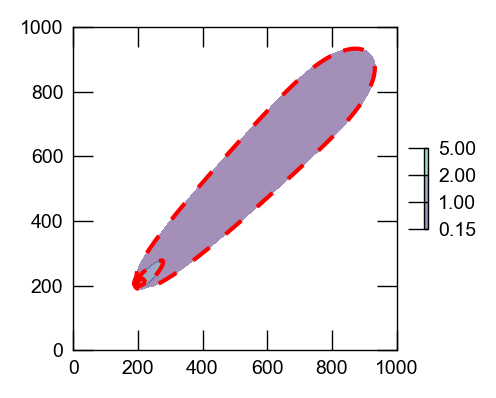

In [8]:
scenario(0)  #  1   2 

Compares the respective TVD solutions between MT3D and MF6.